# Predcition of Hospital Admission Related to Combination of Upper Respiratory Tract Infections 

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to combination of Upper Respiratory Tract Infections (urti_combined). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process urti_combined data
def proc_infec_data_combined_urti(data, infection):
    #rename variables with i
    for i in range(1,21):
        data.rename(columns={infection+'_date_'+str(i): 'urti_combined_date_'+str(i), infection+'_ab_date_'+str(i): 'urti_combined_ab_date_'+str(i),
                            infection+'_ab_type_'+str(i): 'urti_combined_ab_type_'+str(i), 'incdt_'+infection+'_date_'+str(i): 'incdt_urti_combined_date_'+str(i), 
                            'incdt_'+infection+'_type_'+str(i): 'incdt_urti_combined_type_'+str(i), 'admitted_'+infection+'_date_'+str(i): 'admitted_urti_combined_date_'+str(i),
                            'gp_covid_date_'+infection+'_'+str(i): 'gp_covid_date_combined_urti_'+str(i), 'sgss_gp_cov_'+infection+'_date_'+str(i): 'sgss_gp_cov_urti_combined_date_'+str(i),
                            'sgss_pos_covid_date_'+infection+'_'+str(i): 'sgss_pos_covid_date_urti_combined_'+str(i), infection+'_ab_count_'+str(i): 'urti_combined_ab_count_'+str(i)},
                    inplace=True)
    
    return data

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_combined_date_'+str(i), 'urti_combined_ab_date_'+str(i), 'urti_combined_ab_type_'+str(i),
                   'incdt_urti_combined_date_'+str(i), 'admitted_urti_combined_date_'+str(i), 'sgss_gp_cov_urti_combined_date_'+str(i)]]
    
    #drop rows with no urti_combined reord
    datum = datum[datum['urti_combined_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_combined_i
    datum = datum[datum['sgss_gp_cov_urti_combined_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_combined_date_'+str(i): 'urti_combined_date', 'urti_combined_ab_date_'+str(i): 'urti_combined_ab_date', 
                           'urti_combined_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_combined_date_'+str(i): 'incdt_urti_combined_date', 'incdt_urti_combined_type_'+str(i): 'incdt_urti_combined_type',
                           'admitted_urti_combined_date_'+str(i): 'admitted_urti_combined_date',
                           'sgss_gp_cov_urti_combined_date_'+str(i): 'sgss_gp_cov_urti_combined_date'},
                inplace=True)
    
    return datum

In [6]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def cox_build(infection, infection_type, data, data_no_abs): #data_urti_combined_incdt, data_urti_combined_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_urti_combined_admitted',
            event_col='event_urti_combined_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_urti_combined_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_combined_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [9]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [10]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [11]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [12]:
#read datasets 
data_urti = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')
data_urti_combined = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')
data_urti_combined_cold = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')
data_throat = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [13]:
#convert data into combined_urti and concatenate them
data_urti_converted = proc_infec_data_combined_urti(data_urti, 'urti')
data_urti_combined_converted = proc_infec_data_combined_urti(data_urti_combined, 'urti_combined')
data_urti_combined_cold_converted = proc_infec_data_combined_urti(data_urti_combined_cold, 'urti_combined_cold')
data_throat_converted = proc_infec_data_combined_urti(data_throat, 'throat')

frames = [data_urti_converted, data_urti_combined_converted, data_urti_combined_cold_converted, data_throat_converted]
data = pd.concat(frames)

In [14]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [15]:
#process 20 urti_combineds and concatenate them 
data_urti_combined_1 = proc_infec_data(data,1)
data_urti_combined_2 = proc_infec_data(data,2)
data_urti_combined_3 = proc_infec_data(data,3)
data_urti_combined_4 = proc_infec_data(data,4)
data_urti_combined_5 = proc_infec_data(data,5)
data_urti_combined_6 = proc_infec_data(data,6)
data_urti_combined_7 = proc_infec_data(data,7)
data_urti_combined_8 = proc_infec_data(data,8)
data_urti_combined_9 = proc_infec_data(data,9)
data_urti_combined_10 = proc_infec_data(data,10)
data_urti_combined_11 = proc_infec_data(data,11)
data_urti_combined_12 = proc_infec_data(data,12)
data_urti_combined_13 = proc_infec_data(data,13)
data_urti_combined_14 = proc_infec_data(data,14)
data_urti_combined_15 = proc_infec_data(data,15)
data_urti_combined_16 = proc_infec_data(data,16)
data_urti_combined_17 = proc_infec_data(data,17)
data_urti_combined_18 = proc_infec_data(data,18)
data_urti_combined_19 = proc_infec_data(data,19)
data_urti_combined_20 = proc_infec_data(data,20)

data_urti_combined = pd.concat([data_urti_combined_1, data_urti_combined_2, data_urti_combined_3, data_urti_combined_4, data_urti_combined_5, data_urti_combined_6, data_urti_combined_7, data_urti_combined_8, data_urti_combined_9, data_urti_combined_10, data_urti_combined_11, data_urti_combined_12, data_urti_combined_13, data_urti_combined_14, data_urti_combined_15, data_urti_combined_16, data_urti_combined_17, data_urti_combined_18, data_urti_combined_19, data_urti_combined_20])
data_urti_combined.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [16]:
##add variable season
#convert data types
data_urti_combined['urti_combined_date'] = data_urti_combined['urti_combined_date'].astype('datetime64[ns]')
data_urti_combined['admitted_urti_combined_date'] = data_urti_combined['admitted_urti_combined_date'].astype('datetime64[ns]')
data_urti_combined.died_date = data_urti_combined.died_date.astype('datetime64[ns]')
data_urti_combined.deregistered_date = data_urti_combined.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti_combined['date'] = data_urti_combined['urti_combined_date'] 
data_urti_combined['date'] = data_urti_combined['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti_combined with today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_1_month_date_y_m]
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti_combined records
data_urti_combined['season'] = np.nan
data_urti_combined['date_month'] = pd.DatetimeIndex(data_urti_combined['date']).month

conditions = [
    (data_urti_combined['date_month'] >= 3) & (data_urti_combined['date_month'] <= 5),
    (data_urti_combined['date_month'] >= 6) & (data_urti_combined['date_month'] <= 8),
    (data_urti_combined['date_month'] >= 9) & (data_urti_combined['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti_combined['season'] = np.select(conditions, choices, default='winter')

In [17]:
#add variable time period
data_urti_combined.loc[(data_urti_combined['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti_combined.loc[((data_urti_combined['date'] >= '2020-01') & (data_urti_combined['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_urti_combined.loc[(data_urti_combined['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [18]:
data_urti_combined['date'].max()

'2023-03'

#### event and duration

In [19]:
#scenario 1
#not hosped (nothing happened)
data_urti_combined.loc[data_urti_combined['admitted_urti_combined_date'].isnull(), 'event_urti_combined_admitted'] = 0

In [20]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti_combined['delta_urti_combined_admitted'] = (data_urti_combined['admitted_urti_combined_date'] - data_urti_combined['urti_combined_date']).dt.days
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] >= 0) & (data_urti_combined['delta_urti_combined_admitted'] <= 30)), 'event_urti_combined_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti_combined consultation, i.e. negative value for delta_urti_combined_admitted
data_urti_combined = data_urti_combined[~(data_urti_combined['delta_urti_combined_admitted'] < 0)]

In [21]:
#scenario 3
#censor died patients
data_urti_combined['delta_admitted_died'] = (data_urti_combined['died_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_died'] >= 0) & (data_urti_combined['delta_admitted_died'] <= 30)), 'event_urti_combined_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti_combined['delta_admitted_deregistered'] = (data_urti_combined['deregistered_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_deregistered'] > 0) & (data_urti_combined['delta_admitted_deregistered'] <= 30)), 'event_urti_combined_admitted'] = 0

#agg scenario 3s
data_urti_combined['delta_admitted_died_deregistered'] = data_urti_combined['delta_admitted_deregistered'].combine_first(data_urti_combined['delta_admitted_died'])
data_urti_combined.loc[data_urti_combined['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [22]:
#scenario 1
#any other patients (nothing happened)
data_urti_combined['event_urti_combined_admitted'] = data_urti_combined['event_urti_combined_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['delta_urti_combined_admitted'].combine_first(data_urti_combined['delta_admitted_died_deregistered'])
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['duration_urti_combined_admitted'].replace(np.NaN, 30)
data_urti_combined.loc[(data_urti_combined['duration_urti_combined_admitted'] > 30), 'duration_urti_combined_admitted'] = 30

#give value 1 to event_urti_combined_admitted if duration_urti_combined_admitted is greater or equal to 0 and less than 30
data_urti_combined.loc[((data_urti_combined['duration_urti_combined_admitted'] >= 0) & (data_urti_combined['duration_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti_combined = data_urti_combined[~(data_urti_combined['duration_urti_combined_admitted'] == 0)]

In [23]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] > 0) & (data_urti_combined['delta_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [24]:
#drop anybody with age less than 18 or 0!
data_urti_combined = data_urti_combined[~(data_urti_combined['age'] < 18)] 
data_urti_combined['age'][data_urti_combined['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '0-4']
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti_combined['bmi'][data_urti_combined['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti_combined['bmi'] = data_urti_combined['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti_combined['antibacterial_brit'][data_urti_combined['antibacterial_brit'] < 0] = np.nan

In [25]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"smoking": dict_smoking})

In [26]:
#drop rows with missing region
if ('region' in data_urti_combined.columns) and (data_urti_combined['region'].isnull().sum() > 0):
   data_urti_combined = data_urti_combined[data_urti_combined['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti_combined.columns) and (data_urti_combined['antibacterial_brit'].isnull().sum() > 0):
    data_urti_combined['antibacterial_brit'] = data_urti_combined['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti_combined.columns) and (data_urti_combined['ethnicity'].isnull().sum() > 0):
    data_urti_combined['ethnicity'] = data_urti_combined['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_urti_combined.columns) and (data_urti_combined['smoking'].isnull().sum() > 0):
    data_urti_combined['smoking'] = data_urti_combined['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti_combined.columns) and (data_urti_combined['imd'].isnull().sum() > 0):
    data_urti_combined['imd'] = data_urti_combined['imd'].fillna(0)

In [27]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti_combined['bmi_cat'] = 5

for idx, x in enumerate(data_urti_combined['bmi_cat']):
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 30:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 25) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 30):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 18.5) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 25):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 18.5:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti_combined.columns) and (data_urti_combined['bmi_cat'].isnull().sum() > 0):
    data_urti_combined['bmi_cat'] = data_urti_combined['bmi_cat'].fillna(0)

In [28]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti_combined.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti_combined['ab_type_cat'] = np.where(data_urti_combined['ab_type'].isin(ab_series[mask].index),'other',data_urti_combined['ab_type'])
#assign no to non ab users
data_urti_combined.loc[data_urti_combined['urti_combined_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti_combined['ab_type_cat'] = data_urti_combined['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [29]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"ethnicity": dict_ethnicity})
data_urti_combined = data_urti_combined.replace({"smoking": dict_smoking})
data_urti_combined = data_urti_combined.replace({"imd": dict_imd})
data_urti_combined = data_urti_combined.replace({"bmi_cat": dict_bmi})
data_urti_combined = data_urti_combined.replace({"flu_vaccine": dict_flu})
data_urti_combined = data_urti_combined.replace({"region": dict_region})
data_urti_combined = data_urti_combined.replace({"age_cat": dict_age})
data_urti_combined = data_urti_combined.replace({"ab_type_cat": dict_ab_type})

In [30]:
data_urti_combined.ethnicity.value_counts('NA')

white      0.599013
unknown    0.250056
other      0.076128
asian      0.074804
Name: ethnicity, dtype: float64

In [31]:
data_urti_combined.smoking.value_counts('NA')

unknown         0.414671
smoker          0.390342
never_smoked    0.129248
ex_smoker       0.065739
Name: smoking_status, dtype: float64

In [32]:
data_urti_combined.bmi_cat.value_counts('NA')

obese             0.520293
unknown           0.254515
overweight        0.112592
healthy_weight    0.080511
underweight       0.032089
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [33]:
#categorise CCI
data_urti_combined['CCI_cat'] = pd.cut(data_urti_combined['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti_combined['antibacterial_brit'].clip(0, data_urti_combined['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

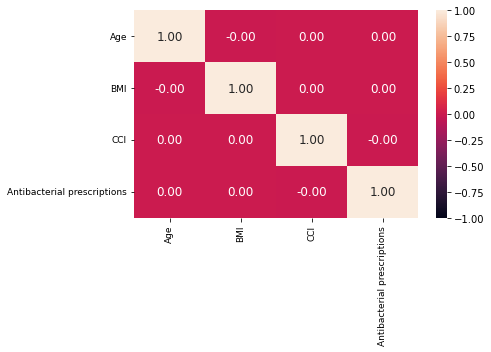

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti_combined[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti_combined/corr_urti_combined.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [35]:
data_urti_combined = data_urti_combined[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'urti_combined_ab_date', 'ab_type_cat', 'incdt_urti_combined_date', 'date', 'period',
                                   'event_urti_combined_admitted', 'duration_urti_combined_admitted'
                                    ]]

In [36]:
#switch variable urti_combined_ab_date into a binary variable
data_urti_combined[['ab_binary']] = data_urti_combined[['urti_combined_ab_date']].where(data_urti_combined[['urti_combined_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_urti_combined_incdt = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 0]
data_urti_combined_prevl = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 1]

#no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt = data_urti_combined_incdt[data_urti_combined_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_urti_combined_abs_incdt = data_urti_combined_incdt[data_urti_combined_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_urti_combined_no_abs_prevl = data_urti_combined_prevl[data_urti_combined_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_urti_combined_abs_prevl = data_urti_combined_prevl[data_urti_combined_prevl['ab_binary'] == 1]

In [37]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_urti_combined_incdt_prepandemic = data_urti_combined_incdt[data_urti_combined_incdt['period'] == 'prepandemic']
data_urti_combined_incdt_during_pandemic = data_urti_combined_incdt[(data_urti_combined_incdt['period'] == 'during_pandemic')]
data_urti_combined_incdt_post_2nd_lockdown = data_urti_combined_incdt[data_urti_combined_incdt['period'] == 'post_2nd_lockdown']
data_urti_combined_prevl_prepandemic = data_urti_combined_prevl[data_urti_combined_prevl['period'] == 'prepandemic']
data_urti_combined_prevl_during_pandemic = data_urti_combined_prevl[(data_urti_combined_prevl['period'] == 'during_pandemic')]
data_urti_combined_prevl_post_2nd_lockdown = data_urti_combined_prevl[data_urti_combined_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt_prepandemic = data_urti_combined_incdt_prepandemic[data_urti_combined_incdt_prepandemic['ab_binary'] == 0]
data_urti_combined_no_abs_incdt_during_pandemic = data_urti_combined_incdt_during_pandemic[data_urti_combined_incdt_during_pandemic['ab_binary'] == 0]
data_urti_combined_no_abs_incdt_post_2nd_lockdown = data_urti_combined_incdt_post_2nd_lockdown[data_urti_combined_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_prepandemic = data_urti_combined_prevl_prepandemic[data_urti_combined_prevl_prepandemic['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_during_pandemic = data_urti_combined_prevl_during_pandemic[data_urti_combined_prevl_during_pandemic['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_post_2nd_lockdown = data_urti_combined_prevl_post_2nd_lockdown[data_urti_combined_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_urti_combined
# save data
data_urti_combined.to_csv('../output/hospitalisation_prediction_urti_combined/data_urti_combined.csv')

Stored 'data_urti_combined' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [39]:
#make summary tables
make_summary_table('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt)
make_summary_table('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt)
make_summary_table('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl)
make_summary_table('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 216279 total observations, 214891 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 216279
number of events observed = 1388
   partial log-likelihood = -17029.80
         time fit was run = 2023-06-29 10:41:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.08            -0.14             0.18                 0.87                 1.20
CCI_cat[T.medium]                0.16       1.17       0.09            -0.02             0.33                 0.98                 1.39
CCI_cat[T.high]                  0.12       1.13       0.10            -0.09             0.32                 0.92                 1.38
CCI_cat[T.very_high]            -0.00       1.00       0.10            -0.19             0.18                 0.83                 1.20
age_cat[T.25_34]                -0.09       0.91       0.10            -0.29             0.11                 0.75                 1.11
age_cat[T.35_44]                 0.00       1.00       0.10            -0.19             0.20                 0.83                 1.22
age_cat[T.45_54]                -0.06       0.94       0.10            -0.26             0.13                 0.77                 1.14
age_cat[T.55_64]                -0.02       0.98       0.10            -0.22             0.17                 0.81                 1.19
age_cat[T.65_74]                -0.11       0.90       0.10            -0.31             0.09                 0.74                 1.10
age_cat[T.75_more]              -0.02       0.98       0.10            -0.22             0.17                 0.80                 1.18
antibacterial_brit               0.02       1.02       0.02            -0.02             0.06                 0.98                 1.06
bmi_cat[T.obese]                 0.14       1.14       0.11            -0.08             0.35                 0.93                 1.41
bmi_cat[T.overweight]            0.17       1.18       0.13            -0.08             0.42                 0.92                 1.52
bmi_cat[T.underweight]           0.20       1.22       0.18            -0.14             0.55                 0.87                 1.73
bmi_cat[T.unknown]               0.10       1.10       0.11            -0.13             0.32                 0.88                 1.38
ethnicity[T.other]               0.23       1.26       0.14            -0.04             0.50                 0.96                 1.64
ethnicity[T.unknown]             0.00       1.00       0.12            -0.23             0.23                 0.79                 1.26
ethnicity[T.white]               0.13       1.14       0.11            -0.08             0.35                 0.92                 1.41
flu_vaccine[T.yes]               0.13       1.14       0.09            -0.04             0.30                 0.96                 1.35
imd[T.medium]                   -0.01       0.99       0.08            -0.18             0.16                 0.84                 1.17
imd[T.unaffluent]               -0.09       0.91       0.09            -0.26             0.08                 0.77                 1.08
imd[T.unknown]                  -0.03       0.97       0.13            -0.29             0.23                 0.75                 1.26
imd[T.very_affluent]            -0.12       0.89       0.09            -0.29             0.05                 0.75                 1.05
imd[T.very_unaffluent]          -0.06       0.94       0.09            -0.23             0.11                 0.79                 1.11
region[T.east_midlands]         -0.15       0

13068


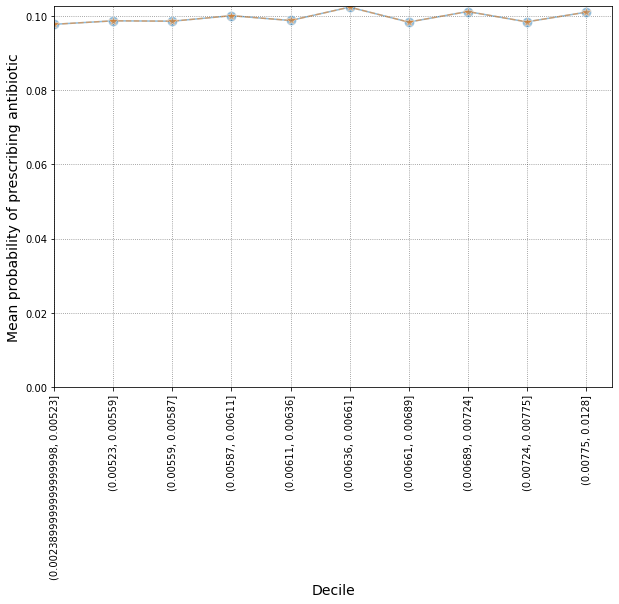


AUROC of LR for deciles with development and validation data: 0.50485 and 0.50158
AUROC of RF for deciles with development and validation data: 0.50485 and 0.50096
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0023899999999999998, 0.00523]  0.110148  0.105579  0.114915
bins_(0.00523, 0.00559]                0.110746  0.106166  0.115523
bins_(0.00559, 0.00587]                0.109441  0.104893  0.114186
bins_(0.00587, 0.00611]                0.110772  0.106191  0.115549
bins_(0.00611, 0.00636]                0.109653  0.105103  0.114400
bins_(0.00636, 0.00661]                0.115204  0.110514  0.120093
bins_(0.00661, 0.00689]                0.108919  0.104385  0.113649
bins_(0.00689, 0.00724]                0.113072  0.108437  0.117905
bins_(0.00724, 0.00775]                0.108392  0.103877  0.113103
bins_(0.00775, 0.0128]                 0.112113  0.107516  0.116905

RF feature importance:
                                         rf_c

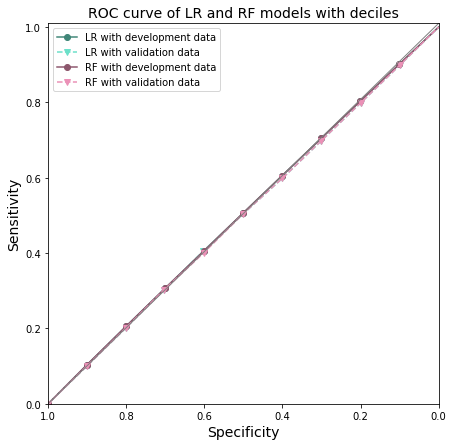

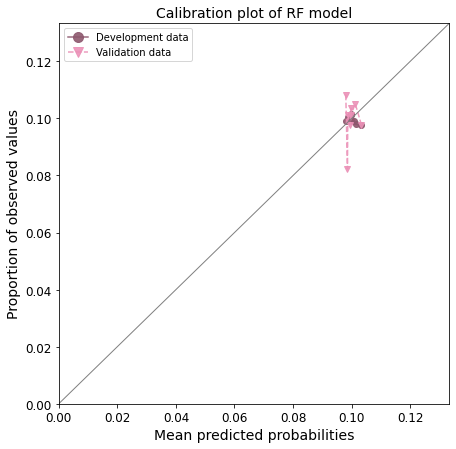

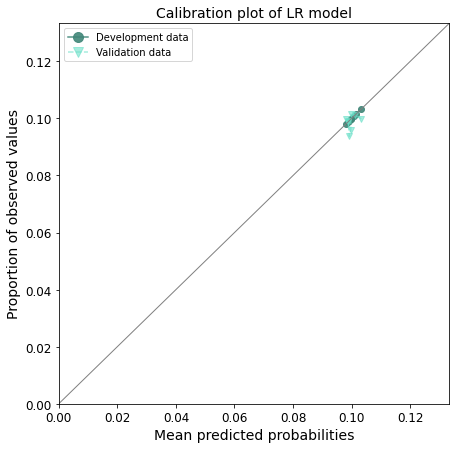


AUROC of LR for risk factors with development and validation data: 0.51390 and 0.49428
AUROC of RF for risk factors with development and validation data: 0.57778 and 0.49602
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.888845       NaN       NaN
age_cat_25_34                0.907546       NaN       NaN
age_cat_35_44                0.924697       NaN       NaN
age_cat_45_54                0.862021       NaN       NaN
age_cat_55_64                0.874220       NaN       NaN
age_cat_65_74                0.877543       NaN       NaN
age_cat_75_more              0.859455       NaN       NaN
sex_female                   0.654802       NaN       NaN
sex_male                     0.647462       NaN       NaN
CCI_cat_high                 0.827620       NaN       NaN
CCI_cat_low                  0.836163       NaN       NaN
CCI_cat_medium               0.856278       NaN       NaN
CCI_cat_very_high            0.827075       NaN      

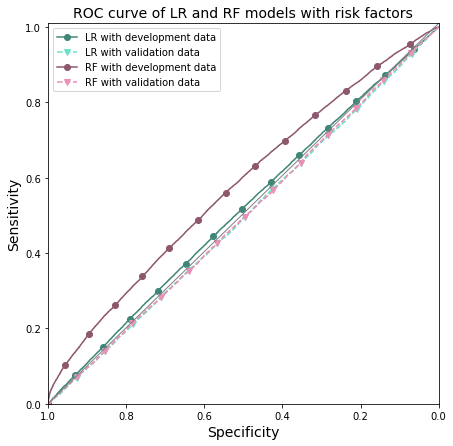

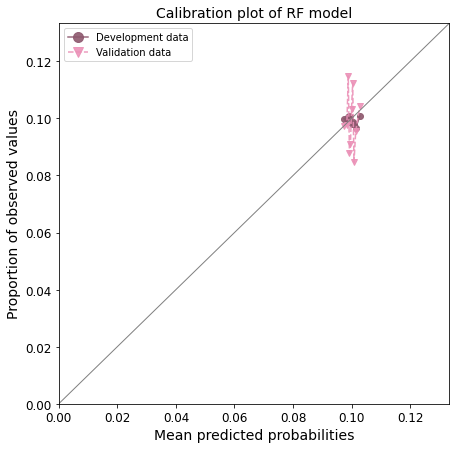

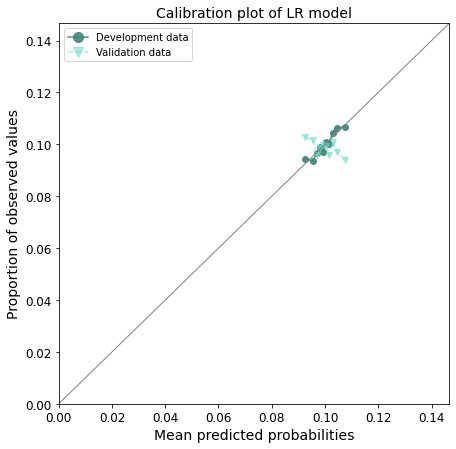

In [40]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt, prob_pred_urti_combined_no_abs_incdt_bin = cox_build('urti_combined', 'incdt', data_urti_combined_incdt, data_urti_combined_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('urti_combined', 'incdt_deciles', prob_pred_urti_combined_no_abs_incdt)

#make summary table of deciles
make_summary_table_deciles('urti_combined', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('urti_combined', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('urti_combined', 'incdt_riskfactors', prob_pred_urti_combined_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('urti_combined', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 23819 total observations, 23691 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 23819
number of events observed = 128
   partial log-likelihood = -1273.08
         time fit was run = 2023-06-29 10:43:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.52       1.68       0.30            -0.07             1.11                 0.93                 3.04
CCI_cat[T.medium]                0.48       1.61       0.33            -0.17             1.12                 0.85                 3.06
CCI_cat[T.high]                  0.28       1.32       0.39            -0.49             1.05                 0.61                 2.86
CCI_cat[T.very_high]             0.52       1.69       0.34            -0.14             1.18                 0.87                 3.26
age_cat[T.25_34]                -0.10       0.90       0.32            -0.72             0.52                 0.48                 1.68
age_cat[T.35_44]                -0.05       0.95       0.31            -0.67             0.56                 0.51                 1.75
age_cat[T.45_54]                 0.11       1.11       0.30            -0.48             0.69                 0.62                 2.00
age_cat[T.55_64]                -0.22       0.80       0.33            -0.86             0.42                 0.42                 1.52
age_cat[T.65_74]                -0.21       0.81       0.33            -0.85             0.43                 0.43                 1.53
age_cat[T.75_more]              -0.76       0.47       0.38            -1.52            -0.01                 0.22                 0.99
antibacterial_brit               0.09       1.10       0.06            -0.02             0.21                 0.98                 1.24
bmi_cat[T.obese]                -0.17       0.85       0.31            -0.78             0.45                 0.46                 1.57
bmi_cat[T.overweight]            0.02       1.02       0.38            -0.72             0.76                 0.49                 2.15
bmi_cat[T.underweight]          -0.10       0.90       0.58            -1.24             1.03                 0.29                 2.80
bmi_cat[T.unknown]              -0.21       0.81       0.34            -0.88             0.46                 0.41                 1.58
ethnicity[T.other]              -0.27       0.76       0.47            -1.18             0.64                 0.31                 1.90
ethnicity[T.unknown]            -0.07       0.93       0.35            -0.75             0.61                 0.47                 1.84
ethnicity[T.white]              -0.13       0.88       0.32            -0.76             0.51                 0.47                 1.66
flu_vaccine[T.yes]               0.05       1.06       0.28            -0.50             0.61                 0.61                 1.84
imd[T.medium]                   -0.14       0.87       0.33            -0.78             0.50                 0.46                 1.64
imd[T.unaffluent]                0.53       1.70       0.28            -0.03             1.09                 0.97                 2.96
imd[T.unknown]                   0.60       1.82       0.40            -0.19             1.38                 0.83                 3.99
imd[T.very_affluent]             0.16       1.18       0.30            -0.43             0.76                 0.65                 2.13
imd[T.very_unaffluent]           0.19       1.21       0.30            -0.40             0.78                 0.67                 2.19
region[T.east_midlands]         -0.31       0.73  

13063


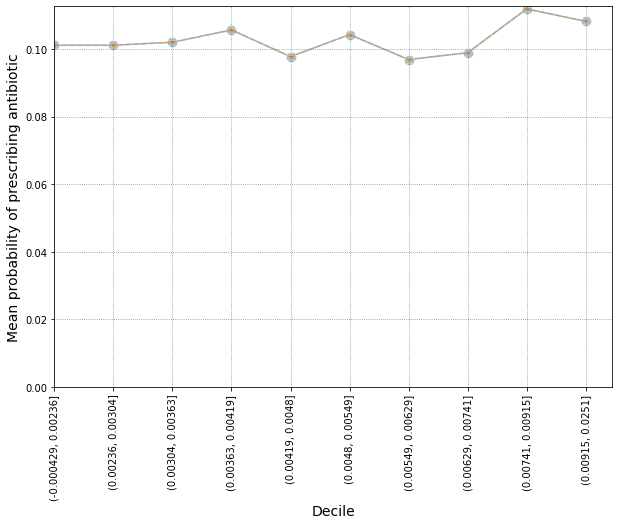


AUROC of LR for deciles with development and validation data: 0.51684 and 0.49660
AUROC of RF for deciles with development and validation data: 0.51682 and 0.49758
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000429, 0.00236]  0.110970  0.097698  0.126046
bins_(0.00236, 0.00304]    0.106383  0.093615  0.120892
bins_(0.00304, 0.00363]    0.115531  0.101927  0.130952
bins_(0.00363, 0.00419]    0.122905  0.108701  0.138965
bins_(0.00419, 0.0048]     0.109640  0.096580  0.124466
bins_(0.0048, 0.00549]     0.115243  0.101879  0.130360
bins_(0.00549, 0.00629]    0.103058  0.090382  0.117512
bins_(0.00629, 0.00741]    0.105946  0.093070  0.120605
bins_(0.00741, 0.00915]    0.125161  0.110800  0.141384
bins_(0.00915, 0.0251]     0.112971  0.099613  0.128120

RF feature importance:
                             rf_coef
bins_(0.00741, 0.00915]    0.200174
bins_(0.00363, 0.00419]    0.154235
bins_(0.00549, 0.00629]    0.138627
bins_(0.00629, 0.00741]    0.096

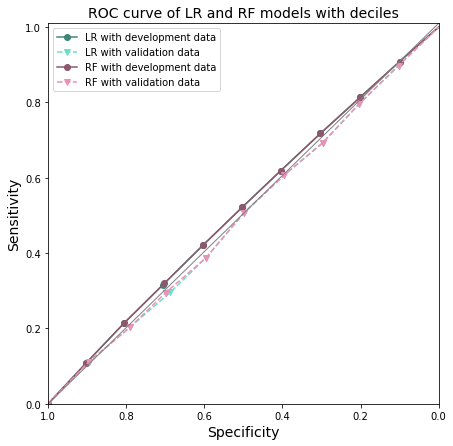

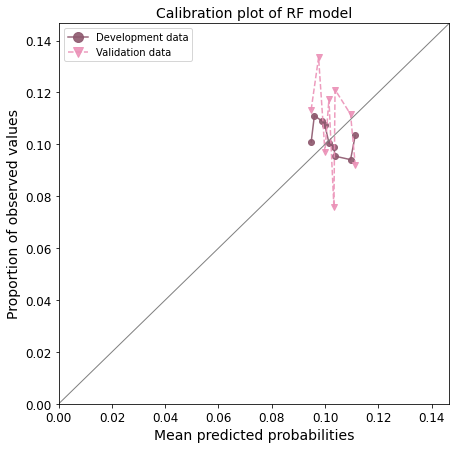

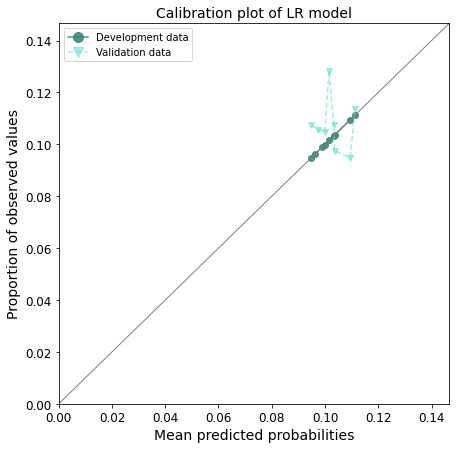


AUROC of LR for risk factors with development and validation data: 0.53346 and 0.48678
AUROC of RF for risk factors with development and validation data: 0.72674 and 0.47985
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.873034       NaN       NaN
age_cat_25_34                0.849158       NaN       NaN
age_cat_35_44                0.920201       NaN       NaN
age_cat_45_54                0.900135       NaN       NaN
age_cat_55_64                0.879908       NaN       NaN
age_cat_65_74                0.894584       NaN       NaN
age_cat_75_more              0.888558       NaN       NaN
sex_female                   0.664034  0.000000       inf
sex_male                     0.646792  0.000000       inf
CCI_cat_high                 0.818083       NaN       NaN
CCI_cat_low                  0.871347       NaN       NaN
CCI_cat_medium               0.819255       NaN       NaN
CCI_cat_very_high            0.848551       NaN      

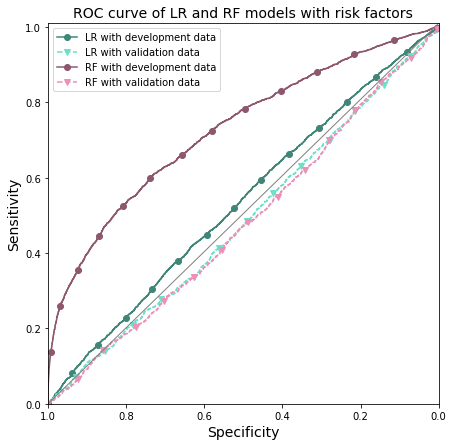

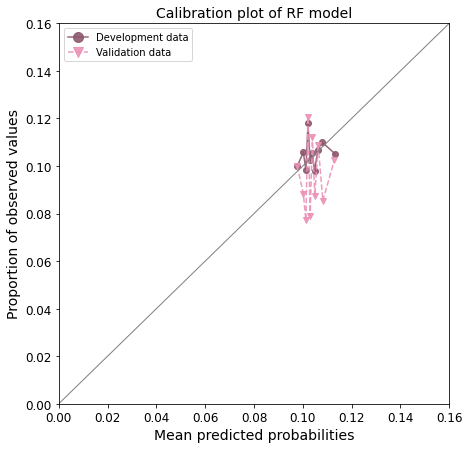

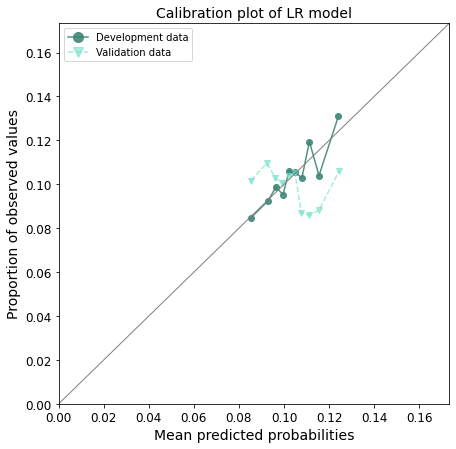

In [41]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl, prob_pred_urti_combined_no_abs_prevl_bin = cox_build('urti_combined', 'prevl', data_urti_combined_prevl, data_urti_combined_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('urti_combined', 'prevl_deciles', prob_pred_urti_combined_no_abs_prevl)

#make summary table of deciles
make_summary_table_deciles('urti_combined', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('urti_combined', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('urti_combined', 'prevl_riskfactors', prob_pred_urti_combined_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('urti_combined', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 57276 total observations, 56942 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 57276
number of events observed = 334
   partial log-likelihood = -3638.14
         time fit was run = 2023-06-29 10:44:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.32       0.18            -0.07             0.63                 0.94                 1.87
CCI_cat[T.medium]                0.44       1.56       0.19             0.08             0.81                 1.08                 2.24
CCI_cat[T.high]                  0.06       1.06       0.24            -0.41             0.53                 0.66                 1.70
CCI_cat[T.very_high]             0.18       1.19       0.21            -0.22             0.58                 0.80                 1.79
age_cat[T.25_34]                 0.05       1.05       0.19            -0.32             0.42                 0.72                 1.53
age_cat[T.35_44]                -0.04       0.96       0.19            -0.42             0.34                 0.66                 1.41
age_cat[T.45_54]                -0.36       0.70       0.21            -0.77             0.06                 0.46                 1.06
age_cat[T.55_64]                -0.29       0.75       0.21            -0.70             0.12                 0.50                 1.12
age_cat[T.65_74]                -0.21       0.81       0.20            -0.61             0.19                 0.54                 1.20
age_cat[T.75_more]              -0.12       0.89       0.20            -0.51             0.27                 0.60                 1.31
antibacterial_brit              -0.03       0.97       0.04            -0.10             0.05                 0.90                 1.05
bmi_cat[T.obese]                 0.20       1.22       0.22            -0.23             0.63                 0.79                 1.89
bmi_cat[T.overweight]            0.14       1.15       0.27            -0.38             0.66                 0.68                 1.94
bmi_cat[T.underweight]           0.38       1.46       0.34            -0.28             1.05                 0.75                 2.85
bmi_cat[T.unknown]               0.04       1.04       0.24            -0.43             0.51                 0.65                 1.66
ethnicity[T.other]               0.34       1.41       0.31            -0.26             0.95                 0.77                 2.57
ethnicity[T.unknown]             0.27       1.30       0.26            -0.25             0.78                 0.78                 2.18
ethnicity[T.white]               0.40       1.49       0.25            -0.08             0.88                 0.92                 2.42
flu_vaccine[T.yes]               0.04       1.04       0.18            -0.32             0.39                 0.73                 1.48
imd[T.medium]                    0.16       1.17       0.17            -0.18             0.50                 0.84                 1.65
imd[T.unaffluent]                0.24       1.27       0.17            -0.10             0.57                 0.91                 1.77
imd[T.unknown]                   0.06       1.07       0.27            -0.47             0.60                 0.62                 1.83
imd[T.very_affluent]            -0.18       0.84       0.19            -0.55             0.19                 0.58                 1.21
imd[T.very_unaffluent]          -0.10       0.90       0.18            -0.46             0.26                 0.63                 1.30
region[T.east_midlands]          0.19       1.21  

13051


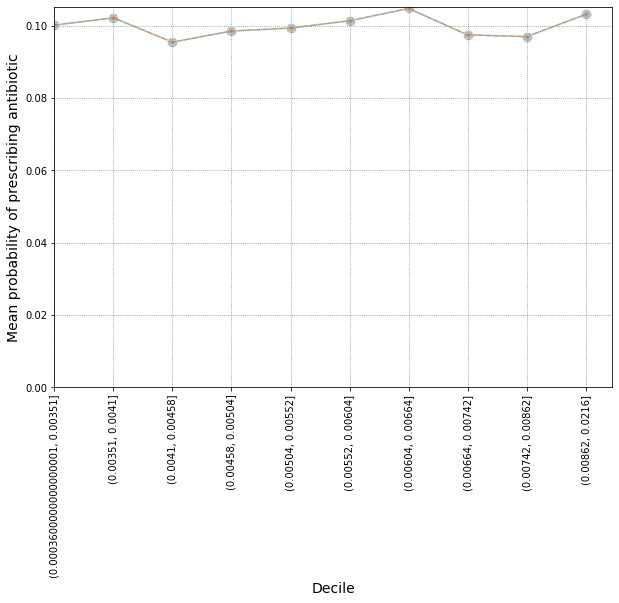


AUROC of LR for deciles with development and validation data: 0.51056 and 0.49804
AUROC of RF for deciles with development and validation data: 0.51054 and 0.49929
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0003600000000000001, 0.00351]  0.110143  0.101457  0.119573
bins_(0.00351, 0.0041]                 0.110625  0.101899  0.120098
bins_(0.0041, 0.00458]                 0.103316  0.094934  0.112438
bins_(0.00458, 0.00504]                0.112778  0.104019  0.122275
bins_(0.00504, 0.00552]                0.108677  0.100066  0.118029
bins_(0.00552, 0.00604]                0.114886  0.105968  0.124554
bins_(0.00604, 0.00664]                0.115277  0.106340  0.124964
bins_(0.00664, 0.00742]                0.110334  0.101626  0.119789
bins_(0.00742, 0.00862]                0.105568  0.097057  0.114826
bins_(0.00862, 0.0216]                 0.117441  0.108420  0.127213

RF feature importance:
                                         rf_c

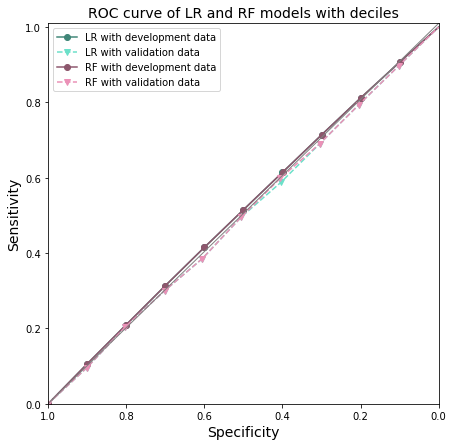

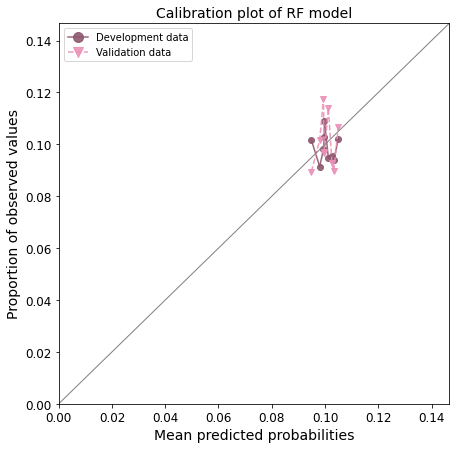

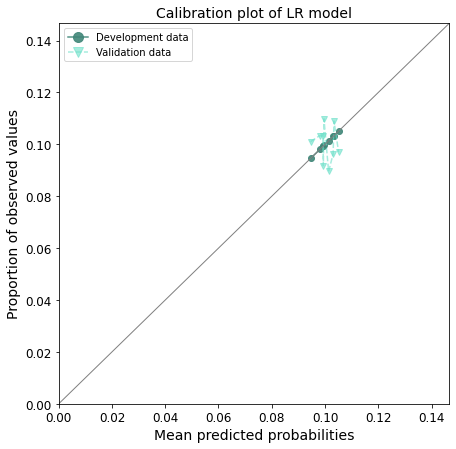

In [42]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_prepandemic, prob_pred_urti_combined_no_abs_incdt_prepandemic_bin = cox_build('urti_combined', 'incdt_prepandemic', data_urti_combined_incdt_prepandemic, data_urti_combined_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('urti_combined', 'incdt_prepandemic', prob_pred_urti_combined_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 66363 total observations, 65925 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 66363
number of events observed = 438
   partial log-likelihood = -4845.83
         time fit was run = 2023-06-29 10:44:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.15            -0.34             0.23                 0.71                 1.26
CCI_cat[T.medium]                0.20       1.22       0.15            -0.10             0.50                 0.90                 1.64
CCI_cat[T.high]                  0.10       1.10       0.19            -0.27             0.46                 0.76                 1.58
CCI_cat[T.very_high]             0.03       1.03       0.17            -0.30             0.35                 0.74                 1.43
age_cat[T.25_34]                 0.13       1.14       0.18            -0.22             0.49                 0.80                 1.63
age_cat[T.35_44]                 0.22       1.25       0.18            -0.13             0.57                 0.88                 1.77
age_cat[T.45_54]                 0.21       1.23       0.18            -0.14             0.56                 0.87                 1.75
age_cat[T.55_64]                 0.22       1.24       0.18            -0.13             0.57                 0.88                 1.76
age_cat[T.65_74]                -0.05       0.96       0.19            -0.42             0.33                 0.66                 1.39
age_cat[T.75_more]              -0.13       0.87       0.19            -0.51             0.25                 0.60                 1.28
antibacterial_brit               0.02       1.02       0.03            -0.05             0.08                 0.95                 1.09
bmi_cat[T.obese]                -0.04       0.96       0.18            -0.40             0.31                 0.67                 1.37
bmi_cat[T.overweight]            0.06       1.06       0.22            -0.37             0.48                 0.69                 1.62
bmi_cat[T.underweight]           0.18       1.20       0.30            -0.40             0.76                 0.67                 2.15
bmi_cat[T.unknown]              -0.08       0.92       0.19            -0.46             0.30                 0.63                 1.35
ethnicity[T.other]              -0.10       0.91       0.22            -0.53             0.33                 0.59                 1.40
ethnicity[T.unknown]            -0.40       0.67       0.18            -0.76            -0.04                 0.47                 0.96
ethnicity[T.white]              -0.31       0.74       0.16            -0.63             0.02                 0.53                 1.02
flu_vaccine[T.yes]               0.14       1.15       0.15            -0.16             0.43                 0.85                 1.54
imd[T.medium]                   -0.03       0.97       0.16            -0.33             0.28                 0.72                 1.32
imd[T.unaffluent]                0.01       1.01       0.15            -0.30             0.31                 0.74                 1.36
imd[T.unknown]                   0.16       1.17       0.23            -0.29             0.61                 0.75                 1.84
imd[T.very_affluent]             0.08       1.09       0.15            -0.22             0.38                 0.81                 1.46
imd[T.very_unaffluent]          -0.08       0.93       0.16            -0.39             0.23                 0.68                 1.26
region[T.east_midlands]         -0.22       0.80  

13063


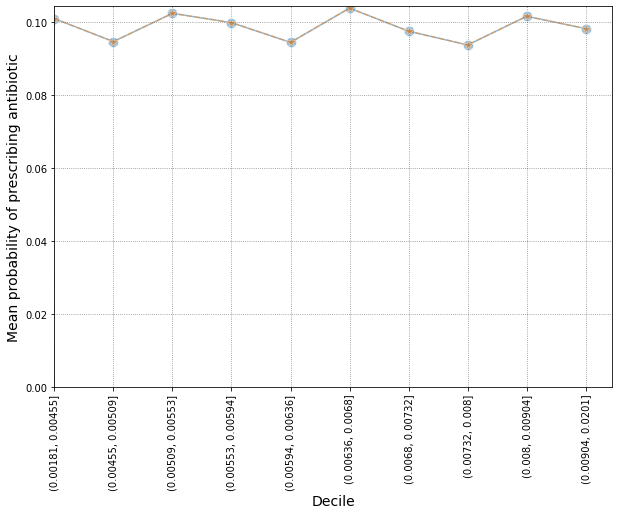


AUROC of LR for deciles with development and validation data: 0.51246 and 0.50311
AUROC of RF for deciles with development and validation data: 0.51246 and 0.50311
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00181, 0.00455]  0.113088  0.104864  0.121958
bins_(0.00455, 0.00509]  0.103900  0.096109  0.112322
bins_(0.00509, 0.00553]  0.110659  0.102542  0.119420
bins_(0.00553, 0.00594]  0.110743  0.102624  0.119505
bins_(0.00594, 0.00636]  0.099103  0.091502  0.107336
bins_(0.00636, 0.0068]   0.116968  0.108554  0.126034
bins_(0.0068, 0.00732]   0.110608  0.102484  0.119377
bins_(0.00732, 0.008]    0.103531  0.095721  0.111979
bins_(0.008, 0.00904]    0.111413  0.103248  0.120224
bins_(0.00904, 0.0201]   0.108867  0.100791  0.117590

RF feature importance:
                           rf_coef
bins_(0.00594, 0.00636]  0.263580
bins_(0.00636, 0.0068]   0.177258
bins_(0.00732, 0.008]    0.104841
bins_(0.00455, 0.00509]  0.096418
bins_(0.00181, 0.00455]  0.0

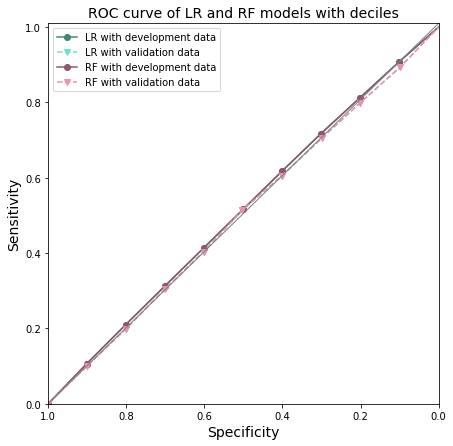

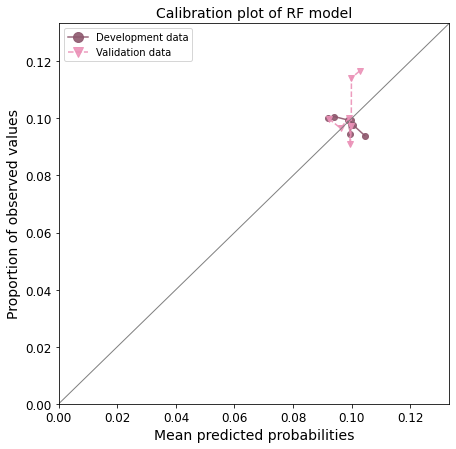

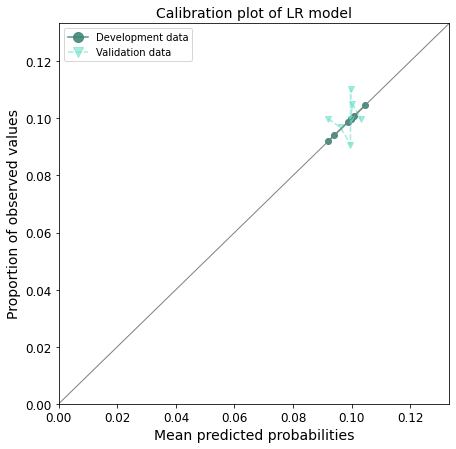

In [43]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_during_pandemic, prob_pred_urti_combined_no_abs_incdt_during_pandemic_bin = cox_build('urti_combined', 'incdt_during_pandemic', data_urti_combined_incdt_during_pandemic, data_urti_combined_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('urti_combined', 'incdt_during_pandemic', prob_pred_urti_combined_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 92639 total observations, 92017 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 92639
number of events observed = 622
   partial log-likelihood = -7092.69
         time fit was run = 2023-06-29 10:44:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.07       0.12            -0.17             0.31                 0.84                 1.36
CCI_cat[T.medium]                0.13       1.14       0.13            -0.13             0.39                 0.87                 1.47
CCI_cat[T.high]                  0.12       1.12       0.16            -0.19             0.43                 0.83                 1.53
CCI_cat[T.very_high]             0.01       1.01       0.14            -0.27             0.29                 0.77                 1.34
age_cat[T.25_34]                -0.09       0.91       0.16            -0.40             0.22                 0.67                 1.24
age_cat[T.35_44]                 0.03       1.03       0.15            -0.27             0.33                 0.76                 1.39
age_cat[T.45_54]                -0.09       0.92       0.16            -0.39             0.22                 0.67                 1.25
age_cat[T.55_64]                 0.22       1.25       0.15            -0.07             0.50                 0.94                 1.66
age_cat[T.65_74]                 0.13       1.14       0.15            -0.16             0.43                 0.86                 1.53
age_cat[T.75_more]               0.07       1.08       0.15            -0.22             0.37                 0.80                 1.44
antibacterial_brit               0.03       1.03       0.03            -0.03             0.08                 0.97                 1.08
bmi_cat[T.obese]                 0.17       1.19       0.16            -0.14             0.49                 0.87                 1.63
bmi_cat[T.overweight]           -0.16       0.85       0.20            -0.56             0.24                 0.57                 1.27
bmi_cat[T.underweight]           0.09       1.10       0.27            -0.44             0.63                 0.64                 1.88
bmi_cat[T.unknown]               0.21       1.23       0.17            -0.13             0.54                 0.88                 1.71
ethnicity[T.other]               0.27       1.30       0.20            -0.13             0.67                 0.87                 1.95
ethnicity[T.unknown]             0.06       1.06       0.17            -0.28             0.40                 0.75                 1.50
ethnicity[T.white]               0.11       1.11       0.16            -0.21             0.43                 0.81                 1.53
flu_vaccine[T.yes]              -0.03       0.97       0.13            -0.30             0.23                 0.74                 1.26
imd[T.medium]                    0.06       1.06       0.12            -0.18             0.30                 0.83                 1.36
imd[T.unaffluent]               -0.12       0.89       0.13            -0.37             0.14                 0.69                 1.15
imd[T.unknown]                  -0.08       0.92       0.20            -0.48             0.32                 0.62                 1.38
imd[T.very_affluent]            -0.15       0.86       0.13            -0.41             0.11                 0.66                 1.11
imd[T.very_unaffluent]          -0.06       0.94       0.13            -0.32             0.19                 0.73                 1.21
region[T.east_midlands]         -0.20       0.82  

13062


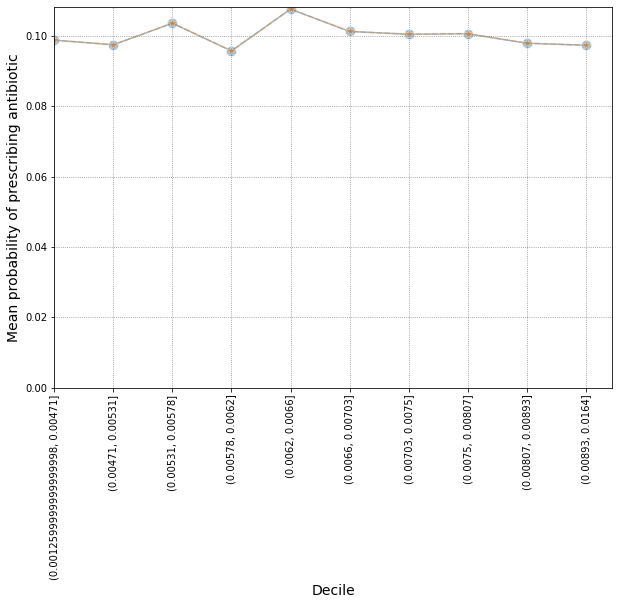


AUROC of LR for deciles with development and validation data: 0.51141 and 0.50298
AUROC of RF for deciles with development and validation data: 0.51141 and 0.50298
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0012599999999999998, 0.00471]  0.112626  0.105635  0.120079
bins_(0.00471, 0.00531]                0.110439  0.103533  0.117806
bins_(0.00531, 0.00578]                0.118018  0.110825  0.125678
bins_(0.00578, 0.0062]                 0.107170  0.100403  0.114392
bins_(0.0062, 0.0066]                  0.121723  0.114399  0.129516
bins_(0.0066, 0.00703]                 0.112637  0.105675  0.120057
bins_(0.00703, 0.0075]                 0.111255  0.104322  0.118649
bins_(0.0075, 0.00807]                 0.110568  0.103633  0.117966
bins_(0.00807, 0.00893]                0.109419  0.102547  0.116751
bins_(0.00893, 0.0164]                 0.104370  0.097698  0.111498

RF feature importance:
                                         rf_c

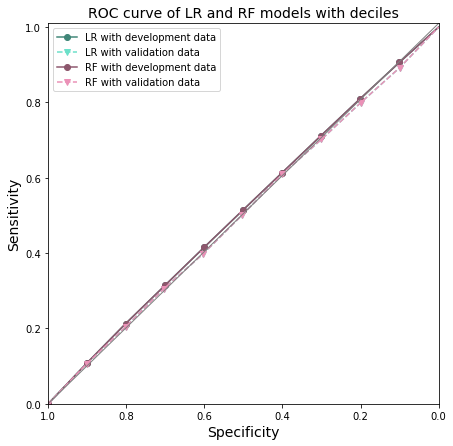

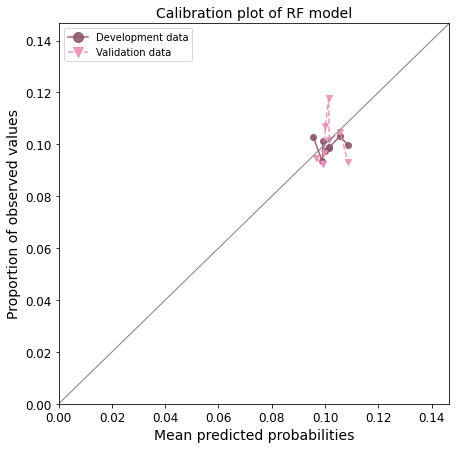

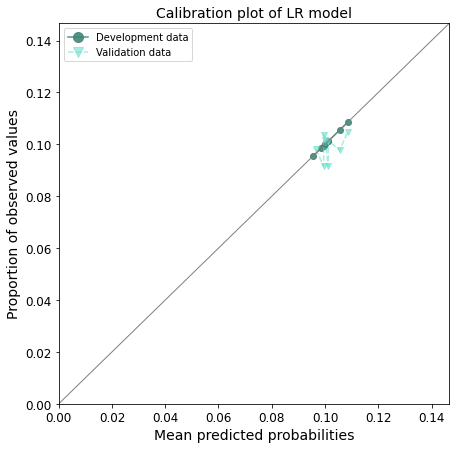

In [44]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown, prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown_bin = cox_build('urti_combined', 'incdt_post_2nd_lockdown', data_urti_combined_incdt_post_2nd_lockdown, data_urti_combined_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('urti_combined', 'incdt_post_2nd_lockdown', prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 6327 total observations, 6293 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 6327
number of events observed = 34
   partial log-likelihood = -271.97
         time fit was run = 2023-06-29 10:45:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.33       0.53            -0.76             1.32                 0.47                 3.76
CCI_cat[T.medium]                0.04       1.05       0.61            -1.15             1.24                 0.32                 3.45
CCI_cat[T.high]                  0.69       1.99       0.61            -0.51             1.88                 0.60                 6.56
CCI_cat[T.very_high]            -0.09       0.92       0.68            -1.42             1.24                 0.24                 3.46
age_cat[T.25_34]                -0.26       0.77       0.67            -1.58             1.06                 0.21                 2.88
age_cat[T.35_44]                -0.02       0.98       0.64            -1.27             1.22                 0.28                 3.40
age_cat[T.45_54]                 0.66       1.94       0.56            -0.44             1.77                 0.64                 5.87
age_cat[T.55_64]                -0.56       0.57       0.73            -1.99             0.88                 0.14                 2.40
age_cat[T.65_74]                 0.30       1.35       0.59            -0.86             1.46                 0.42                 4.29
age_cat[T.75_more]              -1.68       0.19       1.10            -3.83             0.48                 0.02                 1.61
antibacterial_brit               0.10       1.10       0.12            -0.13             0.33                 0.88                 1.38
bmi_cat[T.obese]                -0.55       0.58       0.56            -1.65             0.55                 0.19                 1.74
bmi_cat[T.overweight]           -0.19       0.83       0.68            -1.52             1.14                 0.22                 3.12
bmi_cat[T.underweight]           0.25       1.28       0.88            -1.47             1.96                 0.23                 7.12
bmi_cat[T.unknown]              -0.49       0.61       0.63            -1.73             0.74                 0.18                 2.10
ethnicity[T.other]               0.13       1.13       0.71            -1.28             1.53                 0.28                 4.60
ethnicity[T.unknown]            -0.28       0.76       0.61            -1.47             0.91                 0.23                 2.50
ethnicity[T.white]              -0.53       0.59       0.56            -1.63             0.57                 0.20                 1.77
flu_vaccine[T.yes]              -0.68       0.51       0.73            -2.11             0.76                 0.12                 2.13
imd[T.medium]                    0.39       1.47       0.50            -0.58             1.36                 0.56                 3.89
imd[T.unaffluent]                0.45       1.56       0.49            -0.51             1.40                 0.60                 4.05
imd[T.unknown]                  -0.54       0.58       1.08            -2.65             1.57                 0.07                 4.81
imd[T.very_affluent]            -1.28       0.28       0.81            -2.86             0.30                 0.06                 1.35
imd[T.very_unaffluent]          -0.82       0.44       0.69            -2.17             0.54                 0.11                 1.72
region[T.east_midlands]          1.80       6.05       

13064


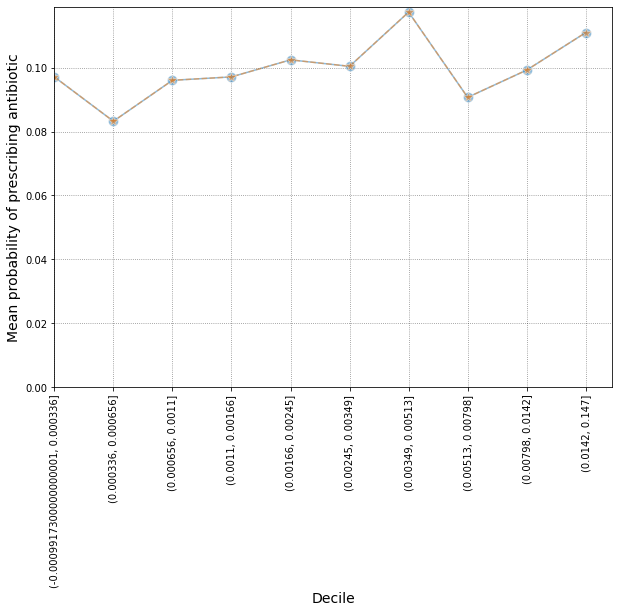


AUROC of LR for deciles with development and validation data: 0.53579 and 0.48856
AUROC of RF for deciles with development and validation data: 0.53558 and 0.48505
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-0.0009917300000000001, 0.000336]  0.109399  0.085627  0.139770
bins_(0.000336, 0.000656]                0.084098  0.063868  0.110736
bins_(0.000656, 0.0011]                  0.111111  0.086645  0.142486
bins_(0.0011, 0.00166]                   0.099369  0.076702  0.128734
bins_(0.00166, 0.00245]                  0.106181  0.082542  0.136590
bins_(0.00245, 0.00349]                  0.123779  0.097530  0.157091
bins_(0.00349, 0.00513]                  0.136218  0.108598  0.170863
bins_(0.00513, 0.00798]                  0.104670  0.081069  0.135141
bins_(0.00798, 0.0142]                   0.110236  0.086124  0.141099
bins_(0.0142, 0.147]                     0.129890  0.103339  0.163264

RF feature importance:
                       

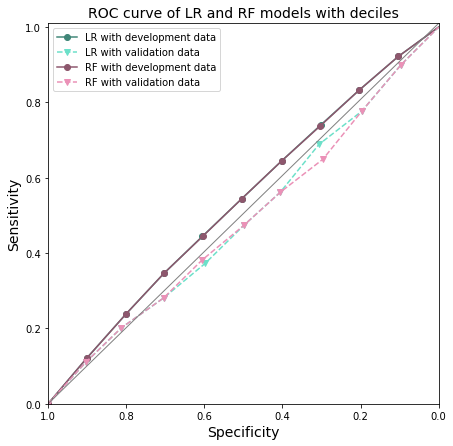

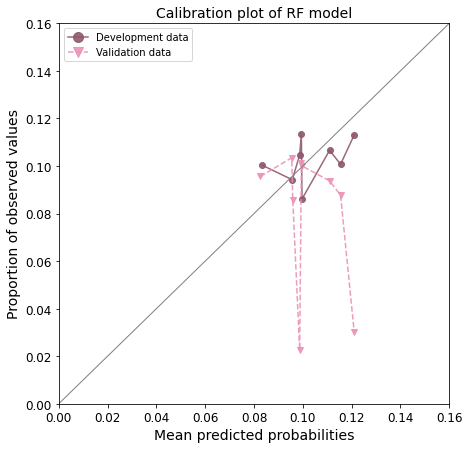

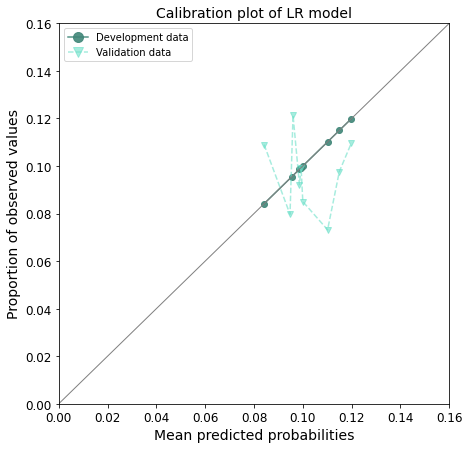

In [45]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_prepandemic, prob_pred_urti_combined_no_abs_prevl_prepandemic_bin = cox_build('urti_combined', 'prevl_prepandemic', data_urti_combined_prevl_prepandemic, data_urti_combined_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('urti_combined', 'prevl_prepandemic', prob_pred_urti_combined_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 7360 total observations, 7319 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7360
number of events observed = 41
   partial log-likelihood = -344.42
         time fit was run = 2023-06-29 10:45:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.50            -0.93             1.01                 0.39                 2.75
CCI_cat[T.medium]                0.10       1.11       0.54            -0.96             1.17                 0.38                 3.21
CCI_cat[T.high]                  0.54       1.71       0.58            -0.60             1.67                 0.55                 5.34
CCI_cat[T.very_high]             0.33       1.39       0.54            -0.73             1.39                 0.48                 4.03
age_cat[T.25_34]                 0.46       1.58       0.57            -0.66             1.58                 0.52                 4.87
age_cat[T.35_44]                -0.01       0.99       0.63            -1.25             1.23                 0.29                 3.44
age_cat[T.45_54]                 0.60       1.82       0.55            -0.48             1.68                 0.62                 5.34
age_cat[T.55_64]                 0.22       1.25       0.59            -0.93             1.37                 0.39                 3.95
age_cat[T.65_74]                -1.68       0.19       1.10            -3.83             0.47                 0.02                 1.60
age_cat[T.75_more]              -0.08       0.93       0.64            -1.32             1.17                 0.27                 3.22
antibacterial_brit               0.08       1.08       0.11            -0.13             0.29                 0.88                 1.33
bmi_cat[T.obese]                -0.41       0.67       0.57            -1.51             0.70                 0.22                 2.02
bmi_cat[T.overweight]            0.73       2.07       0.59            -0.43             1.88                 0.65                 6.54
bmi_cat[T.underweight]           0.82       2.27       0.77            -0.69             2.33                 0.50                10.29
bmi_cat[T.unknown]              -0.39       0.67       0.62            -1.60             0.81                 0.20                 2.26
ethnicity[T.other]              -0.25       0.78       0.92            -2.05             1.55                 0.13                 4.69
ethnicity[T.unknown]            -0.04       0.96       0.67            -1.36             1.27                 0.26                 3.56
ethnicity[T.white]               0.17       1.18       0.61            -1.03             1.37                 0.36                 3.92
flu_vaccine[T.yes]               0.02       1.02       0.53            -1.02             1.06                 0.36                 2.88
imd[T.medium]                   -0.22       0.80       0.45            -1.11             0.67                 0.33                 1.95
imd[T.unaffluent]               -0.09       0.91       0.45            -0.98             0.80                 0.37                 2.22
imd[T.unknown]                 -17.13       0.00    3333.35         -6550.38          6516.12                 0.00                  inf
imd[T.very_affluent]            -0.90       0.41       0.59            -2.05             0.25                 0.13                 1.28
imd[T.very_unaffluent]          -0.26       0.77       0.47            -1.18             0.65                 0.31                 1.92
region[T.east_midlands]         -0.83       0.44       

13079


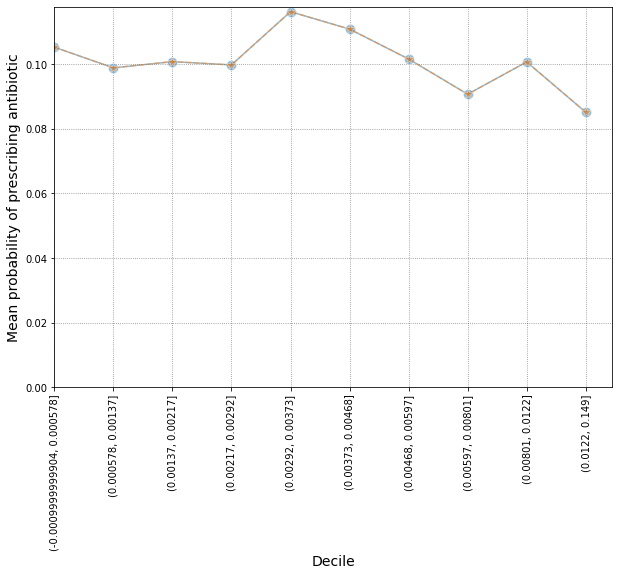


AUROC of LR for deciles with development and validation data: 0.52195 and 0.50825
AUROC of RF for deciles with development and validation data: 0.52165 and 0.49711
LR coefficients:
                                          OR  Lower CI  Upper CI
bins_(-0.0009999999904, 0.000578]  0.103862  0.082261  0.131134
bins_(0.000578, 0.00137]           0.109626  0.087276  0.137699
bins_(0.00137, 0.00217]            0.121951  0.097982  0.151783
bins_(0.00217, 0.00292]            0.110215  0.087740  0.138447
bins_(0.00292, 0.00373]            0.119611  0.095642  0.149586
bins_(0.00373, 0.00468]            0.121127  0.096840  0.151505
bins_(0.00468, 0.00597]            0.108289  0.086103  0.136192
bins_(0.00597, 0.00801]            0.103683  0.081872  0.131306
bins_(0.00801, 0.0122]             0.117808  0.094218  0.147306
bins_(0.0122, 0.149]               0.093458  0.073153  0.119399

RF feature importance:
                                     rf_coef
bins_(0.0122, 0.149]               0.180178


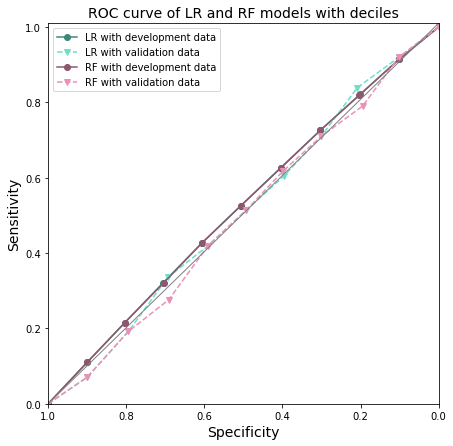

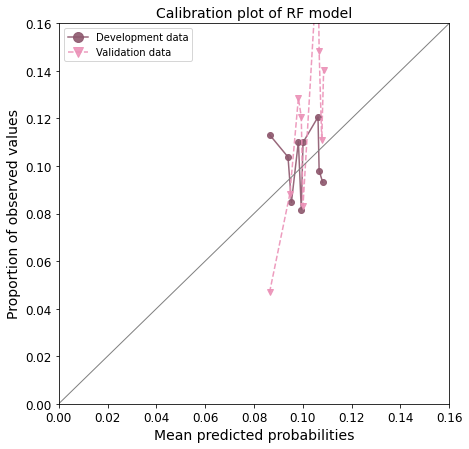

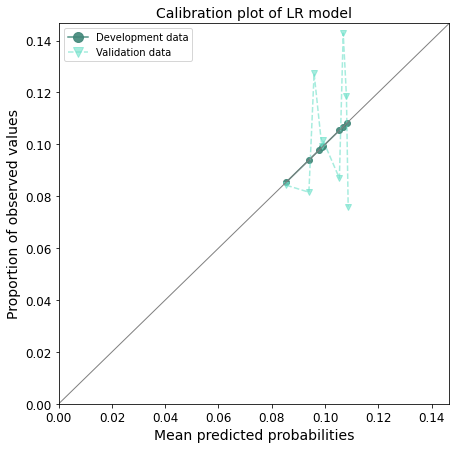

In [46]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_during_pandemic, prob_pred_urti_combined_no_abs_prevl_during_pandemic_bin = cox_build('urti_combined', 'prevl_during_pandemic', data_urti_combined_prevl_during_pandemic, data_urti_combined_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('urti_combined', 'prevl_during_pandemic', prob_pred_urti_combined_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 10131 total observations, 10066 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 10131
number of events observed = 65
   partial log-likelihood = -580.23
         time fit was run = 2023-06-29 10:45:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.38       3.97       0.61             0.18             2.58                 1.20                13.17
CCI_cat[T.medium]                1.55       4.71       0.62             0.33             2.77                 1.39                16.01
CCI_cat[T.high]                  0.43       1.54       0.82            -1.17             2.03                 0.31                 7.63
CCI_cat[T.very_high]             1.71       5.50       0.63             0.47             2.94                 1.60                18.91
age_cat[T.25_34]                -0.29       0.75       0.42            -1.11             0.54                 0.33                 1.72
age_cat[T.35_44]                -0.15       0.86       0.41            -0.96             0.66                 0.38                 1.93
age_cat[T.45_54]                -0.63       0.53       0.47            -1.56             0.29                 0.21                 1.33
age_cat[T.55_64]                -0.16       0.85       0.41            -0.97             0.64                 0.38                 1.90
age_cat[T.65_74]                -0.62       0.54       0.47            -1.54             0.30                 0.21                 1.35
age_cat[T.75_more]              -0.81       0.44       0.49            -1.78             0.16                 0.17                 1.17
antibacterial_brit               0.07       1.07       0.09            -0.10             0.23                 0.90                 1.26
bmi_cat[T.obese]                 1.00       2.73       0.73            -0.42             2.43                 0.66                11.36
bmi_cat[T.overweight]            1.21       3.36       0.78            -0.32             2.75                 0.72                15.56
bmi_cat[T.underweight]           0.37       1.44       1.23            -2.04             2.77                 0.13                15.98
bmi_cat[T.unknown]               1.07       2.91       0.75            -0.39             2.53                 0.67                12.56
ethnicity[T.other]               0.91       2.48       0.69            -0.45             2.26                 0.64                 9.62
ethnicity[T.unknown]             0.25       1.29       0.64            -1.00             1.51                 0.37                 4.54
ethnicity[T.white]               0.60       1.82       0.60            -0.58             1.77                 0.56                 5.87
flu_vaccine[T.yes]               0.16       1.18       0.38            -0.58             0.91                 0.56                 2.47
imd[T.medium]                   -0.01       0.99       0.45            -0.89             0.87                 0.41                 2.39
imd[T.unaffluent]                0.63       1.87       0.40            -0.15             1.40                 0.86                 4.06
imd[T.unknown]                   0.43       1.53       0.59            -0.74             1.59                 0.48                 4.90
imd[T.very_affluent]             0.07       1.07       0.44            -0.79             0.92                 0.45                 2.52
imd[T.very_unaffluent]           0.16       1.17       0.43            -0.68             1.00                 0.50                 2.72
region[T.east_midlands]          0.35       1.42    

13042


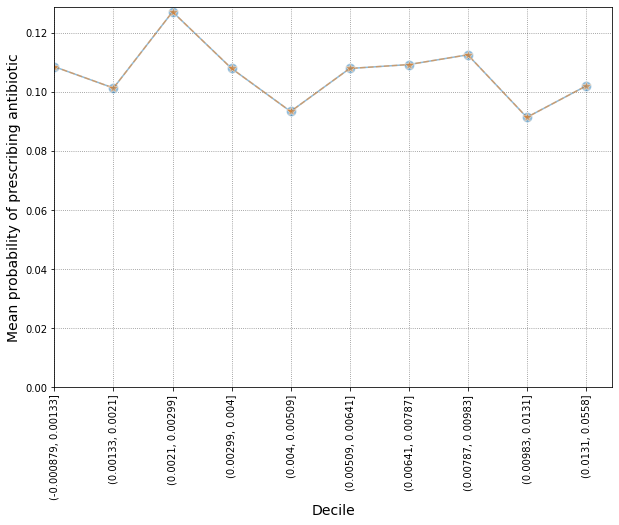


AUROC of LR for deciles with development and validation data: 0.52909 and 0.50632
AUROC of RF for deciles with development and validation data: 0.52897 and 0.50347
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000879, 0.00133]  0.117126  0.096868  0.141620
bins_(0.00133, 0.0021]     0.118110  0.097751  0.142709
bins_(0.0021, 0.00299]     0.136595  0.114036  0.163618
bins_(0.00299, 0.004]      0.131737  0.109873  0.157951
bins_(0.004, 0.00509]      0.101599  0.083353  0.123839
bins_(0.00509, 0.00641]    0.120388  0.099925  0.145042
bins_(0.00641, 0.00787]    0.119447  0.098924  0.144228
bins_(0.00787, 0.00983]    0.113524  0.093611  0.137673
bins_(0.00983, 0.0131]     0.093812  0.075935  0.115899
bins_(0.0131, 0.0558]      0.107843  0.088587  0.131285

RF feature importance:
                             rf_coef
bins_(0.00983, 0.0131]     0.228168
bins_(0.0021, 0.00299]     0.179434
bins_(0.00299, 0.004]      0.138465
bins_(0.004, 0.00509]      0.127

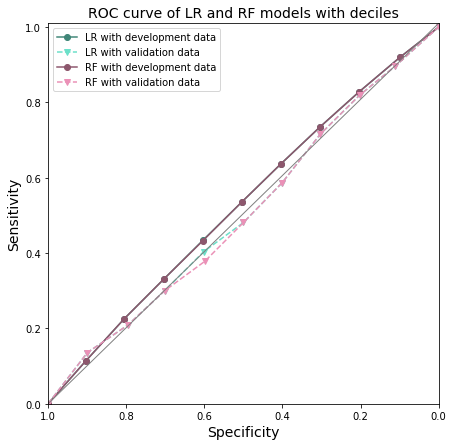

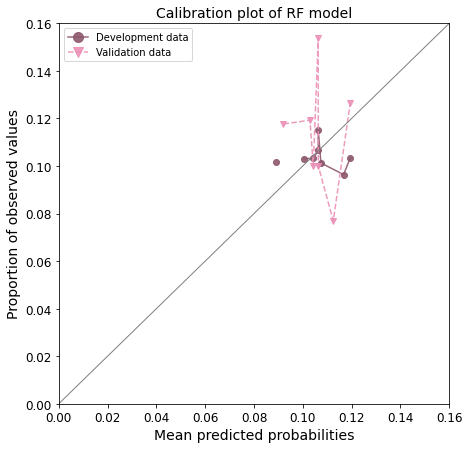

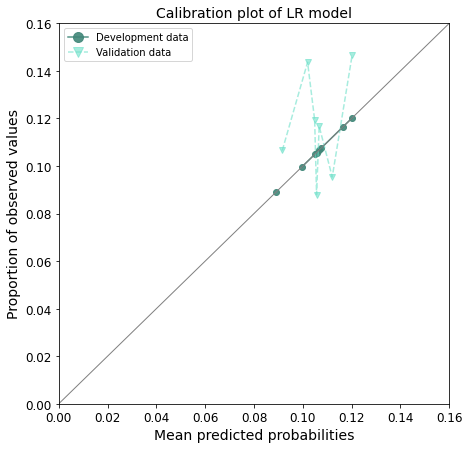

In [47]:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown, prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown_bin = cox_build('urti_combined', 'prevl_post_2nd_lockdown', data_urti_combined_prevl_post_2nd_lockdown, data_urti_combined_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('urti_combined', 'prevl_post_2nd_lockdown', prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)